In [39]:
import numpy as np
import torch
from torch.utils import data
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from matplotlib import image
from matplotlib import patches
import zipfile
from pycocotools.coco import COCO
import pandas as pd
import cv2
import random as rn
%matplotlib inline

In [ ]:
# Download Dataset (Uncomment to download)
# !wget http://images.cocodataset.org/zips/train2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# !mkdir data
# !mv *.zip data/

# Unzip data
# with zipfile.ZipFile('data/train2017.zip', 'r') as zip_ref: zip_ref.extractall('data/')
# with zipfile.ZipFile('data/val2017.zip', 'r') as zip_ref: zip_ref.extractall('data/')
# with zipfile.ZipFile('data/annotations_trainval2017.zip', 'r') as zip_ref: zip_ref.extractall('data/')

In [2]:
# Load annotations for training data
train_annot_path = 'data/annotations/person_keypoints_train2017.json'
val_annot_path = 'data/annotations/person_keypoints_val2017.json'
train_coco = COCO(train_annot_path) # load annotations for training set
val_coco = COCO(val_annot_path) # load annotations for validation set

loading annotations into memory...
Done (t=6.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [3]:
# Load meta data on images: https://towardsdatascience.com/how-to-analyze-the-coco-dataset-for-pose-estimation-7296e2ffb12e
def get_meta(coco):
    ids = list(coco.imgs.keys())
    for i, img_id in enumerate(ids):
        img_meta = coco.imgs[img_id]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # basic parameters of an image
        img_file_name = img_meta['file_name']
        w = img_meta['width']
        h = img_meta['height']
        # retrieve metadata for all persons in the current image
        anns = coco.loadAnns(ann_ids)

        yield [img_id, img_file_name, w, h, anns]
        
def convert_to_df(coco):
    images_data = []
    persons_data = []
    # iterate over all images
    for img_id, img_fname, w, h, meta in get_meta(coco):
        images_data.append({
            'image_id': int(img_id),
            'path': img_fname,
            'width': int(w),
            'height': int(h)
        })
        # iterate over all metadata
        for m in meta:
            persons_data.append({
                'image_id': m['image_id'],
                'is_crowd': m['iscrowd'],
                'bbox': m['bbox'],
                'area': m['area'],
                'num_keypoints': m['num_keypoints'],
                'keypoints': m['keypoints'],
            })
    # create dataframe with image paths
    images_df = pd.DataFrame(images_data)
    images_df.set_index('image_id', inplace=True)
    # create dataframe with persons
    persons_df = pd.DataFrame(persons_data)
    persons_df.set_index('image_id', inplace=True)
    return images_df, persons_df

# Create train and validation dfs
images_df, persons_df = convert_to_df(train_coco)
train_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)

images_df, persons_df = convert_to_df(val_coco)
val_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)

In [4]:
val_coco_df

,path,width,height,is_crowd,bbox,area,num_keypoints,keypoints
image_id,,,,,,,,
139,000000000139.jpg,640,426,0,"[412.8, 157.61, 53.05, 138.01]",2913.11040,15,"[427, 170, 1, 429, 169, 2, 0, 0, 0, 434, 168, ..."
139,000000000139.jpg,640,426,0,"[384.43, 172.21, 15.12, 35.74]",435.14495,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
785,000000000785.jpg,640,425,0,"[280.79, 44.73, 218.7, 346.68]",27789.11055,17,"[367, 81, 2, 374, 73, 2, 360, 75, 2, 386, 78, ..."
872,000000000872.jpg,621,640,0,"[145.26, 100.67, 291.95, 457.35]",25759.04240,12,"[367, 138, 2, 0, 0, 0, 360, 134, 2, 0, 0, 0, 3..."
872,000000000872.jpg,621,640,0,"[163.73, 126.42, 265.69, 480.4]",48091.75195,15,"[211, 187, 1, 215, 179, 2, 0, 0, 0, 241, 175, ..."
...,...,...,...,...,...,...,...,...
581357,000000581357.jpg,612,612,0,"[180.89, 440.51, 21.1, 38.36]",371.49395,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
581357,000000581357.jpg,612,612,0,"[249.22, 419.65, 13.2, 24.53]",169.55635,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
581357,000000581357.jpg,612,612,0,"[211.18, 420.26, 23.38, 40.03]",542.16740,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
# Drop all photos with no keypoints or where a group is just marked as crowd
train_coco_df = train_coco_df[train_coco_df['is_crowd']==0]
train_coco_df = train_coco_df[train_coco_df['num_keypoints']>0]

val_coco_df = val_coco_df[val_coco_df['is_crowd']==0]
val_coco_df = val_coco_df[val_coco_df['num_keypoints']>0]

In [6]:
# Takes in a dataframe and index and outputs a figure of it with keypoints at default dimensions
def displayImageFromDf(coco_df, index):
    img = image.imread(f'data/train2017/{coco_df.iloc[index]["path"]}')
    bbox = coco_df.iloc[index]["bbox"]
    keypoints = coco_df.iloc[index]["keypoints"]

    fig, ax = plt.subplots()
    ax.imshow(img)

    # Show kps
    for i in range(2, len(keypoints), 3):
        ax.plot(keypoints[i-2], keypoints[i-1], marker='x', color="red")

    # Show bbox
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

In [7]:
# Takes in a dataframe and index and outputs a figure of it cropped to 224x224 with keypoints moved
def displayCroppedImageFromDf(coco_df, index):
    img = image.imread(f'data/train2017/{coco_df.iloc[index]["path"]}')
    bbox = np.array(coco_df.iloc[index]["bbox"]).astype(np.int64)
    keypoints = coco_df.iloc[index]["keypoints"]
    
    # Crop image
    img = img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    
    x_scale = 224/img.shape[1]
    y_scale = 224/img.shape[0]
    
    # Scale image
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Show kps
    for i in range(2, len(keypoints), 3):
        x = (keypoints[i-2] - bbox[0]) * x_scale * 1/224
        y = (keypoints[i-1] - bbox[1]) * y_scale * 1/224
        if x < 0: x = 0
        if y < 0: y = 0
            
        ax.plot(x*224, y*224, marker='x', color="red")

    plt.show()

In [31]:
# Takes in a CXHXW image with keypoints and displays it with keypoints
def displayImageWithKeyPoints(img, keypoints, ax=None, show=True):
    img = np.swapaxes(img,0,2)
    img = np.swapaxes(img,0,1)

    #fig = None
    if(ax is None):
        fig, ax = plt.subplots()
    ax.imshow(img)
    w = img.shape[1]
    h = img.shape[0]
    
    # Show kps
    
    for i in range(1, len(keypoints), 2):
        x = keypoints[i-1]
        y = keypoints[i]
        x = (x)*w + w/2
        y = (y)*h + h/2
        if x < 0 or y < 0: continue
        ax.plot(x, y, marker='x', color="red")
    if(show):
        plt.show()

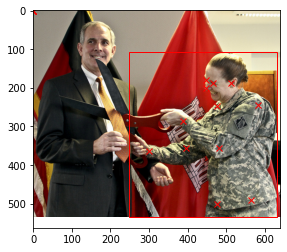

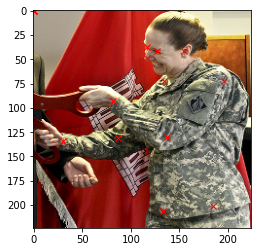

In [32]:
displayImageFromDf(train_coco_df, 21)
displayCroppedImageFromDf(train_coco_df, 21)

In [22]:
# normalizing transform defined in the DeepPose paper
# y is a 2 vec, b is a 4 vec of bcx, bcy, bw, bh
def N(y, b):
    return [ (y[0]-b[0]) * 1/b[2], (y[1]-b[1]) * 1/b[3]]

def Ninv(y, b):
    return []

In [23]:
# Create datasets for training and validation
class Coco(Dataset):
    def __init__(self, df, source, dimensions, transform=None):
        super().__init__()
        # Dataframe of annotations
        self.df = df
        # Either train or val to indicate set
        self.source = source
        # Square dimensions of image
        self.dimensions = dimensions
        # transform
        self.transform = transform

    def __getitem__(self, index):
        # Get data
        img = image.imread(f'data/{self.source}2017/{self.df.iloc[index]["path"]}')
        bbox = np.array(self.df.iloc[index]["bbox"]).astype(np.int64)
        keypoints = self.df.iloc[index]["keypoints"]
        
        # Account for potential gray images by adding channels
        if len(img.shape) == 2 or img.shape[2] == 1:
            if (len(img.shape) == 2): img = np.expand_dims(img,-1)
            img = cv2.merge([img,img,img])
        
        # Crop image to bbox
        img = img[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
        
        # Scale image 
        img = cv2.resize(img, dsize=(self.dimensions, self.dimensions), interpolation=cv2.INTER_CUBIC)

        bbox_tl_x = bbox[0]
        bbox_tl_y = bbox[1]
        w_original = bbox[2]
        h_original = bbox[3]

        bbox_rescale = [self.dimensions/2, self.dimensions/2, self.dimensions, self.dimensions]
        
        # Move keypoints to new bbox locations accounting for crop, scale, and normalization
        final_keypoints = []
        for i in range(2, len(keypoints), 3):
            x = (keypoints[i-2] - bbox_tl_x) * self.dimensions / w_original
            y = (keypoints[i-1] - bbox_tl_y)* self.dimensions / h_original

            x, y = N([x, y], bbox_rescale)

            v = keypoints[i]
            #print(str(x) + " " + str(y))
            
            # If resizing put keypoint outside of image then remove it
            if x < -0.5 or y < -0.5 or x > 0.5 or y > 0.5: v = 0
            
            # Set keypoints to -1 if not visible
            if v == 0:
                x = -1
                y = -1
                
            # Add final keypoints to final_keypoints
            final_keypoints.extend([x,y])
            
        img = img.astype('uint8') # enforce int 
        if self.transform: img = self.transform(img)
            
        return img, torch.FloatTensor(final_keypoints)

    def __len__(self):
        return len(self.df)

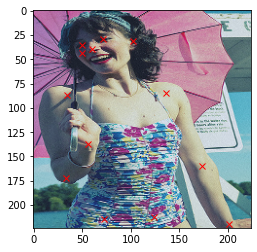

In [33]:
# Data loader
composed_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
train_dataloader = DataLoader(
    dataset=Coco(train_coco_df, 'train', 224, transform=composed_transforms),
    batch_size=1, shuffle=False, num_workers=0
)

# Example from data loader after normalization
img, labels = iter(train_dataloader).next()
a = img[0].numpy()
b = (a - np.min(a))/np.ptp(a)
displayImageWithKeyPoints(b, labels[0])

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("No GPU")

Using the GPU!


In [48]:
# Initialize network
model = models.resnet18(pretrained=True)

# Freeze params
# for param in model.parameters():
# param.requires_grad = False

# Replace FC
model.fc = torch.nn.Linear(512, 4096)
model = torch.nn.Sequential(model, torch.nn.Linear(4096,34))
model.to(device)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
model.load_state_dict(torch.load("model.save", map_location=device))

<All keys matched successfully>

Validiation loss was 117.23473358154297


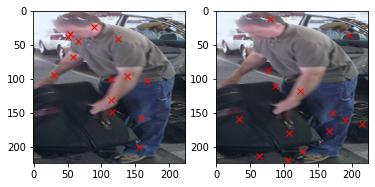

tensor(117.2347, device='cuda:0')

In [44]:
val_dataset = Coco(val_coco_df, 'val', 224, transform=composed_transforms)
batch_size = 32
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')

def check_validation_accuracy(model):
    
    with torch.no_grad():
        loss = 0
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(inputs)
            loss += criterion(outputs, labels)

        print(f"Validiation loss was {loss}")
    
    # visualize some random gt vs prediction
    idx = rn.randint(0, 200)
    img, labels = val_dataset[idx]
    a = img.numpy()
    b = (a - np.min(a))/np.ptp(a)
    
    img = img.to(device)
    outputs = model(img.unsqueeze(0))
    outputs = outputs.to('cpu')

    fig, (ax0, ax1) = plt.subplots(1, 2)
    displayImageWithKeyPoints(b, labels, ax0, False)
    displayImageWithKeyPoints(b, outputs[0].detach().numpy(), ax1, True)

    return loss 
    

check_validation_accuracy(model)

Training 30 epochs. Dataset is 149813 big. Using batch size 32
4682 minibatches are needed per epoch
Minibatch 1/4682. Loss 0.5040239691734314
Minibatch 51/4682. Loss 0.27533578872680664
Minibatch 101/4682. Loss 0.25076034665107727
Minibatch 151/4682. Loss 0.23682746291160583
Minibatch 201/4682. Loss 0.24191688001155853
Minibatch 251/4682. Loss 0.20371422171592712
Minibatch 301/4682. Loss 0.22968950867652893
Minibatch 351/4682. Loss 0.18965353071689606
Minibatch 401/4682. Loss 0.24321286380290985
Minibatch 451/4682. Loss 0.20461979508399963
Minibatch 501/4682. Loss 0.1880490928888321
Minibatch 551/4682. Loss 0.2376536726951599
Minibatch 601/4682. Loss 0.1921408623456955
Minibatch 651/4682. Loss 0.1890435814857483
Minibatch 701/4682. Loss 0.20233504474163055
Minibatch 751/4682. Loss 0.1959104984998703
Minibatch 801/4682. Loss 0.19598305225372314
Minibatch 851/4682. Loss 0.20873159170150757
Minibatch 901/4682. Loss 0.18027105927467346
Minibatch 951/4682. Loss 0.17075423896312714
Minibatc

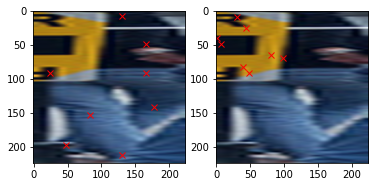

Minibatch 1/4682. Loss 0.13896307349205017
Minibatch 51/4682. Loss 0.1205112636089325
Minibatch 101/4682. Loss 0.11616890877485275
Minibatch 151/4682. Loss 0.12796615064144135
Minibatch 201/4682. Loss 0.1215713694691658
Minibatch 251/4682. Loss 0.105113185942173
Minibatch 301/4682. Loss 0.167577862739563
Minibatch 351/4682. Loss 0.170944944024086
Minibatch 401/4682. Loss 0.1519094705581665
Minibatch 451/4682. Loss 0.10931164771318436
Minibatch 501/4682. Loss 0.12307590991258621
Minibatch 551/4682. Loss 0.13059338927268982
Minibatch 601/4682. Loss 0.13046273589134216
Minibatch 651/4682. Loss 0.11520368605852127
Minibatch 701/4682. Loss 0.10757599025964737
Minibatch 751/4682. Loss 0.11354631930589676
Minibatch 801/4682. Loss 0.11448639631271362
Minibatch 851/4682. Loss 0.1134614422917366
Minibatch 901/4682. Loss 0.1096106544137001
Minibatch 951/4682. Loss 0.15851852297782898
Minibatch 1001/4682. Loss 0.1542922407388687
Minibatch 1051/4682. Loss 0.13114261627197266
Minibatch 1101/4682. Lo

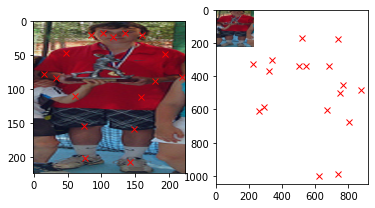

Minibatch 1/4682. Loss 0.09482664614915848
Minibatch 51/4682. Loss 0.12347418814897537
Minibatch 101/4682. Loss 0.09067586064338684
Minibatch 151/4682. Loss 0.10475087910890579
Minibatch 201/4682. Loss 0.11302922666072845
Minibatch 251/4682. Loss 0.120588019490242
Minibatch 301/4682. Loss 0.10545553267002106
Minibatch 351/4682. Loss 0.10847555845975876
Minibatch 401/4682. Loss 0.11160508543252945
Minibatch 451/4682. Loss 0.09522899240255356
Minibatch 501/4682. Loss 0.0939500480890274
Minibatch 551/4682. Loss 0.1016327291727066
Minibatch 601/4682. Loss 0.10706260800361633
Minibatch 651/4682. Loss 0.12679757177829742
Minibatch 701/4682. Loss 0.1730400025844574
Minibatch 751/4682. Loss 0.17557203769683838
Minibatch 801/4682. Loss 0.14115041494369507
Minibatch 851/4682. Loss 0.14788378775119781
Minibatch 901/4682. Loss 0.1471467763185501
Minibatch 951/4682. Loss 0.12107176333665848
Minibatch 1001/4682. Loss 0.12332052737474442
Minibatch 1051/4682. Loss 0.12884852290153503
Minibatch 1101/46

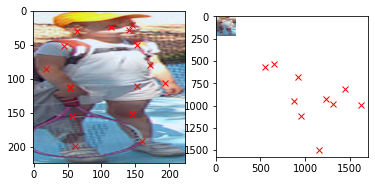

Minibatch 1/4682. Loss 0.09018334001302719
Minibatch 51/4682. Loss 0.09445831924676895
Minibatch 101/4682. Loss 0.11805467307567596
Minibatch 151/4682. Loss 0.10867983102798462
Minibatch 201/4682. Loss 0.09729684889316559
Minibatch 251/4682. Loss 0.1182628944516182
Minibatch 301/4682. Loss 0.09677842259407043
Minibatch 351/4682. Loss 0.10443464666604996
Minibatch 401/4682. Loss 0.09506867825984955
Minibatch 451/4682. Loss 0.11224661767482758
Minibatch 501/4682. Loss 0.08291436731815338
Minibatch 551/4682. Loss 0.09309882670640945
Minibatch 601/4682. Loss 0.10815908014774323
Minibatch 651/4682. Loss 0.1499401181936264
Minibatch 701/4682. Loss 0.1264406442642212
Minibatch 751/4682. Loss 0.09561266750097275
Minibatch 801/4682. Loss 0.10840500146150589
Minibatch 851/4682. Loss 0.07578012347221375
Minibatch 901/4682. Loss 0.12949557602405548
Minibatch 951/4682. Loss 0.09681100398302078
Minibatch 1001/4682. Loss 0.11740045994520187
Minibatch 1051/4682. Loss 0.08989448100328445
Minibatch 1101

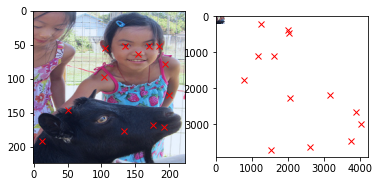

Minibatch 1/4682. Loss 0.0970073714852333
Minibatch 51/4682. Loss 0.10228551924228668
Minibatch 101/4682. Loss 0.09724228829145432
Minibatch 151/4682. Loss 0.12426791340112686
Minibatch 201/4682. Loss 0.09495585411787033
Minibatch 251/4682. Loss 0.1256956160068512
Minibatch 301/4682. Loss 0.10864362865686417
Minibatch 351/4682. Loss 0.10162606090307236
Minibatch 401/4682. Loss 0.10000381618738174
Minibatch 451/4682. Loss 0.09140491485595703
Minibatch 501/4682. Loss 0.09225581586360931
Minibatch 551/4682. Loss 0.10835724323987961
Minibatch 601/4682. Loss 0.11733730882406235
Minibatch 651/4682. Loss 0.11248458176851273
Minibatch 701/4682. Loss 0.10289516299962997
Minibatch 751/4682. Loss 0.094449982047081
Minibatch 801/4682. Loss 0.09594131261110306
Minibatch 851/4682. Loss 0.11336632072925568
Minibatch 901/4682. Loss 0.12710759043693542
Minibatch 951/4682. Loss 0.10346274077892303
Minibatch 1001/4682. Loss 0.09677775949239731
Minibatch 1051/4682. Loss 0.08922266960144043
Minibatch 1101/

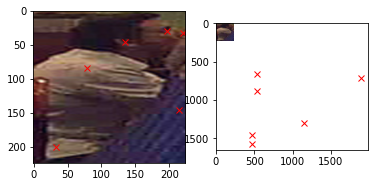

Minibatch 1/4682. Loss 0.08306431770324707
Minibatch 51/4682. Loss 0.1180548220872879
Minibatch 101/4682. Loss 0.09618634730577469
Minibatch 151/4682. Loss 0.08161550760269165
Minibatch 201/4682. Loss 0.07884279638528824
Minibatch 251/4682. Loss 0.09999057650566101
Minibatch 301/4682. Loss 0.1035391166806221
Minibatch 351/4682. Loss 0.10722074657678604
Minibatch 401/4682. Loss 0.09047254174947739
Minibatch 451/4682. Loss 0.09353703260421753
Minibatch 501/4682. Loss 0.09372410178184509
Minibatch 551/4682. Loss 0.09007017314434052
Minibatch 601/4682. Loss 0.11304312199354172
Minibatch 651/4682. Loss 0.08658978343009949
Minibatch 701/4682. Loss 0.10074365884065628
Minibatch 751/4682. Loss 0.09085273742675781
Minibatch 801/4682. Loss 0.07714960724115372
Minibatch 851/4682. Loss 0.08959414809942245
Minibatch 901/4682. Loss 0.08538275957107544
Minibatch 951/4682. Loss 0.08339876681566238
Minibatch 1001/4682. Loss 0.11541728675365448
Minibatch 1051/4682. Loss 0.09804077446460724
Minibatch 110

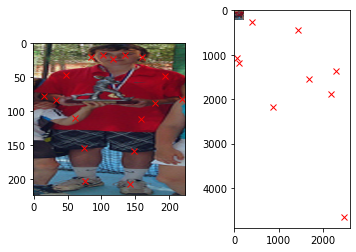

Minibatch 1/4682. Loss 0.10058999806642532
Minibatch 51/4682. Loss 0.08488934487104416
Minibatch 101/4682. Loss 0.08215487748384476
Minibatch 151/4682. Loss 0.09011577069759369
Minibatch 201/4682. Loss 0.06837321072816849
Minibatch 251/4682. Loss 0.09787838160991669
Minibatch 301/4682. Loss 0.08305951952934265
Minibatch 351/4682. Loss 0.0883939117193222
Minibatch 401/4682. Loss 0.09450540691614151
Minibatch 451/4682. Loss 0.08915266394615173
Minibatch 501/4682. Loss 0.09501796960830688
Minibatch 551/4682. Loss 0.08810611814260483
Minibatch 601/4682. Loss 0.08156687021255493
Minibatch 651/4682. Loss 0.0839507132768631
Minibatch 701/4682. Loss 0.10485655814409256
Minibatch 751/4682. Loss 0.09858148545026779
Minibatch 801/4682. Loss 0.08403526991605759
Minibatch 851/4682. Loss 0.0777568370103836
Minibatch 901/4682. Loss 0.09230896085500717
Minibatch 951/4682. Loss 0.08448219299316406
Minibatch 1001/4682. Loss 0.10491661727428436
Minibatch 1051/4682. Loss 0.08680076897144318
Minibatch 1101

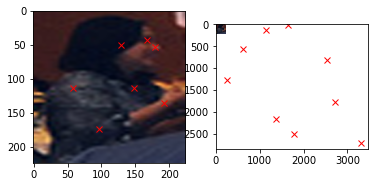

Minibatch 1/4682. Loss 0.07202994078397751
Minibatch 51/4682. Loss 0.08415085077285767
Minibatch 101/4682. Loss 0.06839492172002792
Minibatch 151/4682. Loss 0.07516541332006454
Minibatch 201/4682. Loss 0.07074657827615738
Minibatch 251/4682. Loss 0.07578205317258835
Minibatch 301/4682. Loss 0.09978753328323364
Minibatch 351/4682. Loss 0.07150037586688995
Minibatch 401/4682. Loss 0.07987481355667114
Minibatch 451/4682. Loss 0.07834984362125397
Minibatch 501/4682. Loss 0.07556731253862381
Minibatch 551/4682. Loss 0.089971624314785
Minibatch 601/4682. Loss 0.058064572513103485
Minibatch 651/4682. Loss 0.07951963692903519
Minibatch 701/4682. Loss 0.06813104450702667
Minibatch 751/4682. Loss 0.07632716745138168
Minibatch 801/4682. Loss 0.0690077468752861
Minibatch 851/4682. Loss 0.06780173629522324
Minibatch 901/4682. Loss 0.08932100236415863
Minibatch 951/4682. Loss 0.07885241508483887
Minibatch 1001/4682. Loss 0.06408140808343887
Minibatch 1051/4682. Loss 0.07822299748659134
Minibatch 110

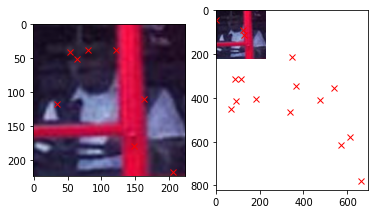

Minibatch 1/4682. Loss 0.06574474275112152
Minibatch 51/4682. Loss 0.09020695835351944
Minibatch 101/4682. Loss 0.05921993404626846
Minibatch 151/4682. Loss 0.05742916092276573
Minibatch 201/4682. Loss 0.07823661714792252
Minibatch 251/4682. Loss 0.08910935372114182
Minibatch 301/4682. Loss 0.05633515492081642
Minibatch 351/4682. Loss 0.07494648545980453
Minibatch 401/4682. Loss 0.0603594072163105
Minibatch 451/4682. Loss 0.08459446579217911
Minibatch 501/4682. Loss 0.07943104952573776
Minibatch 551/4682. Loss 0.07488260418176651
Minibatch 601/4682. Loss 0.06555116176605225
Minibatch 651/4682. Loss 0.08043287694454193
Minibatch 701/4682. Loss 0.07966286689043045
Minibatch 751/4682. Loss 0.08422429114580154
Minibatch 801/4682. Loss 0.04963277280330658
Minibatch 851/4682. Loss 0.057602591812610626
Minibatch 901/4682. Loss 0.06894031167030334
Minibatch 951/4682. Loss 0.0654391497373581
Minibatch 1001/4682. Loss 0.08784395456314087
Minibatch 1051/4682. Loss 0.08895175904035568
Minibatch 11

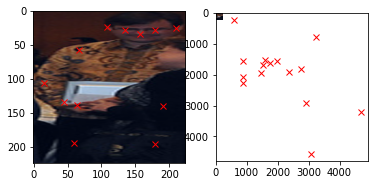

Minibatch 1/4682. Loss 0.08142728358507156
Minibatch 51/4682. Loss 0.07404576987028122
Minibatch 101/4682. Loss 0.06810175627470016
Minibatch 151/4682. Loss 0.056438691914081573
Minibatch 201/4682. Loss 0.06701618432998657
Minibatch 251/4682. Loss 0.07726122438907623
Minibatch 301/4682. Loss 0.061018142849206924
Minibatch 351/4682. Loss 0.059875648468732834
Minibatch 401/4682. Loss 0.08094218373298645
Minibatch 451/4682. Loss 0.06834379583597183
Minibatch 501/4682. Loss 0.06567346304655075
Minibatch 551/4682. Loss 0.06460525095462799
Minibatch 601/4682. Loss 0.09028153121471405
Minibatch 651/4682. Loss 0.07096174359321594
Minibatch 701/4682. Loss 0.07850638031959534
Minibatch 751/4682. Loss 0.08390841633081436
Minibatch 801/4682. Loss 0.0691179409623146
Minibatch 851/4682. Loss 0.08190923929214478
Minibatch 901/4682. Loss 0.07592950016260147
Minibatch 951/4682. Loss 0.07191845774650574
Minibatch 1001/4682. Loss 0.0671888068318367
Minibatch 1051/4682. Loss 0.061911556869745255
Minibatch

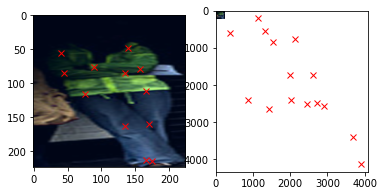

Minibatch 1/4682. Loss 0.05010588839650154
Minibatch 51/4682. Loss 0.0764511302113533
Minibatch 101/4682. Loss 0.04796765744686127
Minibatch 151/4682. Loss 0.07460420578718185
Minibatch 201/4682. Loss 0.06599732488393784
Minibatch 251/4682. Loss 0.05788278579711914
Minibatch 301/4682. Loss 0.07755190134048462
Minibatch 351/4682. Loss 0.05148930847644806
Minibatch 401/4682. Loss 0.06148819997906685
Minibatch 451/4682. Loss 0.06467103958129883
Minibatch 501/4682. Loss 0.05419476330280304
Minibatch 551/4682. Loss 0.06168154999613762
Minibatch 601/4682. Loss 0.058815401047468185
Minibatch 651/4682. Loss 0.07356926053762436
Minibatch 701/4682. Loss 0.05620207637548447
Minibatch 751/4682. Loss 0.06044086441397667
Minibatch 801/4682. Loss 0.06451014429330826
Minibatch 851/4682. Loss 0.059930913150310516
Minibatch 901/4682. Loss 0.061997924000024796
Minibatch 951/4682. Loss 0.08093862235546112
Minibatch 1001/4682. Loss 0.04671201854944229
Minibatch 1051/4682. Loss 0.05853211507201195
Minibatch

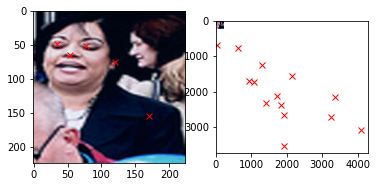

Minibatch 1/4682. Loss 0.05368997901678085
Minibatch 51/4682. Loss 0.0508461557328701
Minibatch 101/4682. Loss 0.06351566314697266
Minibatch 151/4682. Loss 0.06736277043819427
Minibatch 201/4682. Loss 0.056023526936769485
Minibatch 251/4682. Loss 0.0641549676656723
Minibatch 301/4682. Loss 0.06890533864498138
Minibatch 351/4682. Loss 0.07650506496429443
Minibatch 401/4682. Loss 0.0668967217206955
Minibatch 451/4682. Loss 0.06356751918792725
Minibatch 501/4682. Loss 0.06725555658340454
Minibatch 551/4682. Loss 0.07326233386993408
Minibatch 601/4682. Loss 0.06575983762741089
Minibatch 651/4682. Loss 0.06399416923522949
Minibatch 701/4682. Loss 0.054183635860681534
Minibatch 751/4682. Loss 0.0644930973649025
Minibatch 801/4682. Loss 0.06087354198098183
Minibatch 851/4682. Loss 0.06120102480053902
Minibatch 901/4682. Loss 0.06469632685184479
Minibatch 951/4682. Loss 0.05941484868526459
Minibatch 1001/4682. Loss 0.04292794689536095
Minibatch 1051/4682. Loss 0.04778195545077324
Minibatch 110

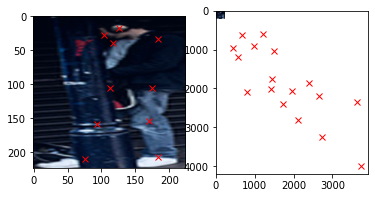

Minibatch 1/4682. Loss 0.040972623974084854
Minibatch 51/4682. Loss 0.051749952137470245
Minibatch 101/4682. Loss 0.06625300645828247
Minibatch 151/4682. Loss 0.04445725306868553
Minibatch 201/4682. Loss 0.054010357707738876
Minibatch 251/4682. Loss 0.0472944900393486
Minibatch 301/4682. Loss 0.05063148960471153
Minibatch 351/4682. Loss 0.06389886885881424
Minibatch 401/4682. Loss 0.04816817492246628
Minibatch 451/4682. Loss 0.052195675671100616
Minibatch 501/4682. Loss 0.05852603167295456
Minibatch 551/4682. Loss 0.05493537709116936
Minibatch 601/4682. Loss 0.05149087682366371
Minibatch 651/4682. Loss 0.056404195725917816
Minibatch 701/4682. Loss 0.047725606709718704
Minibatch 751/4682. Loss 0.05222226306796074
Minibatch 801/4682. Loss 0.04677974060177803
Minibatch 851/4682. Loss 0.05547443777322769
Minibatch 901/4682. Loss 0.05054169148206711
Minibatch 951/4682. Loss 0.05712885409593582
Minibatch 1001/4682. Loss 0.05909005180001259
Minibatch 1051/4682. Loss 0.04301874712109566
Miniba

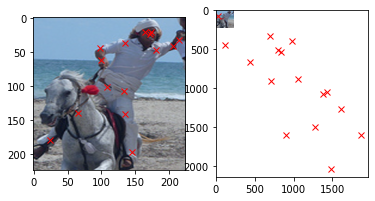

Minibatch 1/4682. Loss 0.042755525559186935
Minibatch 51/4682. Loss 0.039704617112874985
Minibatch 101/4682. Loss 0.0398772768676281
Minibatch 151/4682. Loss 0.04434122145175934
Minibatch 201/4682. Loss 0.04529682919383049
Minibatch 251/4682. Loss 0.054276734590530396
Minibatch 301/4682. Loss 0.0458575077354908
Minibatch 351/4682. Loss 0.05667339637875557
Minibatch 401/4682. Loss 0.048225000500679016
Minibatch 451/4682. Loss 0.038779329508543015
Minibatch 501/4682. Loss 0.04473096504807472
Minibatch 551/4682. Loss 0.0448337197303772
Minibatch 601/4682. Loss 0.042882610112428665
Minibatch 651/4682. Loss 0.06444837152957916
Minibatch 701/4682. Loss 0.04015994817018509
Minibatch 751/4682. Loss 0.05391561985015869
Minibatch 801/4682. Loss 0.04654669016599655
Minibatch 851/4682. Loss 0.06373090296983719
Minibatch 901/4682. Loss 0.05279019847512245
Minibatch 951/4682. Loss 0.04540998116135597
Minibatch 1001/4682. Loss 0.04617682471871376
Minibatch 1051/4682. Loss 0.04240218922495842
Minibatc

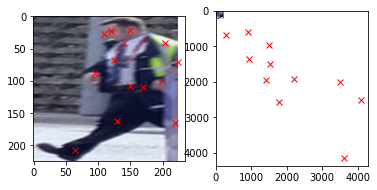

Minibatch 1/4682. Loss 0.041036128997802734
Minibatch 51/4682. Loss 0.04647033289074898
Minibatch 101/4682. Loss 0.03935232013463974
Minibatch 151/4682. Loss 0.049483757466077805
Minibatch 201/4682. Loss 0.0442066453397274
Minibatch 251/4682. Loss 0.04354505613446236
Minibatch 301/4682. Loss 0.03678257018327713
Minibatch 351/4682. Loss 0.04725729674100876
Minibatch 401/4682. Loss 0.04549557343125343
Minibatch 451/4682. Loss 0.02937697432935238
Minibatch 501/4682. Loss 0.049574725329875946
Minibatch 551/4682. Loss 0.034222666174173355
Minibatch 601/4682. Loss 0.03756057471036911
Minibatch 651/4682. Loss 0.04754848778247833
Minibatch 701/4682. Loss 0.05153482034802437
Minibatch 751/4682. Loss 0.03248720243573189
Minibatch 801/4682. Loss 0.04608621820807457
Minibatch 851/4682. Loss 0.04341641068458557
Minibatch 901/4682. Loss 0.04213998094201088
Minibatch 951/4682. Loss 0.04455147311091423
Minibatch 1001/4682. Loss 0.032841894775629044
Minibatch 1051/4682. Loss 0.036341339349746704
Miniba

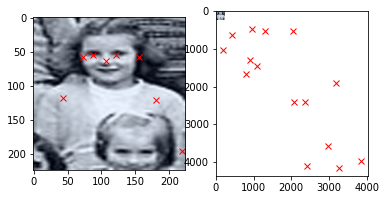

Minibatch 1/4682. Loss 0.04404745250940323
Minibatch 51/4682. Loss 0.04301629215478897
Minibatch 101/4682. Loss 0.041385434567928314
Minibatch 151/4682. Loss 0.03983062133193016
Minibatch 201/4682. Loss 0.03571397438645363
Minibatch 251/4682. Loss 0.044366154819726944
Minibatch 301/4682. Loss 0.045041222125291824
Minibatch 351/4682. Loss 0.03591787815093994
Minibatch 401/4682. Loss 0.045391812920570374
Minibatch 451/4682. Loss 0.031300220638513565
Minibatch 501/4682. Loss 0.04089794307947159
Minibatch 551/4682. Loss 0.03611484542489052
Minibatch 601/4682. Loss 0.0406191311776638
Minibatch 651/4682. Loss 0.039955586194992065
Minibatch 701/4682. Loss 0.04464918002486229
Minibatch 751/4682. Loss 0.04429525509476662
Minibatch 801/4682. Loss 0.03642122447490692
Minibatch 851/4682. Loss 0.03939827159047127
Minibatch 901/4682. Loss 0.05230782926082611
Minibatch 951/4682. Loss 0.038681816309690475
Minibatch 1001/4682. Loss 0.038582999259233475
Minibatch 1051/4682. Loss 0.04892004281282425
Mini

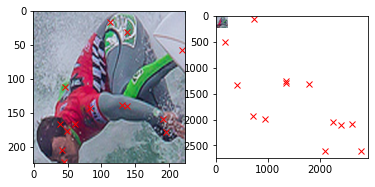

Minibatch 1/4682. Loss 0.0443459190428257
Minibatch 51/4682. Loss 0.04342738166451454
Minibatch 101/4682. Loss 0.03293130174279213
Minibatch 151/4682. Loss 0.025547174736857414
Minibatch 201/4682. Loss 0.03839343413710594
Minibatch 251/4682. Loss 0.03195315971970558
Minibatch 301/4682. Loss 0.045718416571617126
Minibatch 351/4682. Loss 0.036441173404455185
Minibatch 401/4682. Loss 0.03998273238539696
Minibatch 451/4682. Loss 0.030549509450793266
Minibatch 501/4682. Loss 0.03648453950881958
Minibatch 551/4682. Loss 0.03855116665363312
Minibatch 601/4682. Loss 0.03577760234475136
Minibatch 651/4682. Loss 0.03905210271477699
Minibatch 701/4682. Loss 0.05477301403880119
Minibatch 751/4682. Loss 0.04213280230760574
Minibatch 801/4682. Loss 0.03780827298760414
Minibatch 851/4682. Loss 0.03599788621068001
Minibatch 901/4682. Loss 0.03788464888930321
Minibatch 951/4682. Loss 0.037631213665008545
Minibatch 1001/4682. Loss 0.037620995193719864
Minibatch 1051/4682. Loss 0.04638369008898735
Miniba

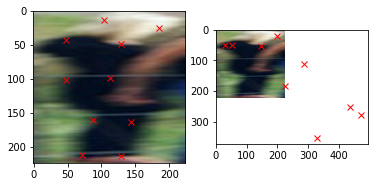

Minibatch 1/4682. Loss 0.04089825227856636
Minibatch 51/4682. Loss 0.031307850033044815
Minibatch 101/4682. Loss 0.03925206512212753
Minibatch 151/4682. Loss 0.030128268525004387
Minibatch 201/4682. Loss 0.03044859506189823
Minibatch 251/4682. Loss 0.028461690992116928
Minibatch 301/4682. Loss 0.0425473116338253
Minibatch 351/4682. Loss 0.035957012325525284
Minibatch 401/4682. Loss 0.03641653060913086
Minibatch 451/4682. Loss 0.03648535534739494
Minibatch 501/4682. Loss 0.03770028427243233
Minibatch 551/4682. Loss 0.03703029081225395
Minibatch 601/4682. Loss 0.02725258469581604
Minibatch 651/4682. Loss 0.04194088280200958
Minibatch 701/4682. Loss 0.03388185054063797
Minibatch 751/4682. Loss 0.029836107045412064
Minibatch 801/4682. Loss 0.03349260613322258
Minibatch 851/4682. Loss 0.03866834565997124
Minibatch 901/4682. Loss 0.0387711264193058
Minibatch 951/4682. Loss 0.03900008276104927
Minibatch 1001/4682. Loss 0.029847880825400352
Minibatch 1051/4682. Loss 0.03558983653783798
Minibat

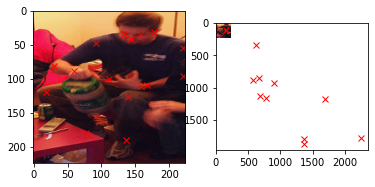

Minibatch 1/4682. Loss 0.03294053673744202
Minibatch 51/4682. Loss 0.03654498979449272
Minibatch 101/4682. Loss 0.04131066054105759
Minibatch 151/4682. Loss 0.0272569190710783
Minibatch 201/4682. Loss 0.04301607608795166
Minibatch 251/4682. Loss 0.04324893280863762
Minibatch 301/4682. Loss 0.024887165054678917
Minibatch 351/4682. Loss 0.026933809742331505
Minibatch 401/4682. Loss 0.03144147992134094
Minibatch 451/4682. Loss 0.03458172082901001
Minibatch 501/4682. Loss 0.04060634970664978
Minibatch 551/4682. Loss 0.02929774671792984
Minibatch 601/4682. Loss 0.038663171231746674
Minibatch 651/4682. Loss 0.03551892936229706
Minibatch 701/4682. Loss 0.0379372276365757
Minibatch 751/4682. Loss 0.02876485325396061
Minibatch 801/4682. Loss 0.028660094365477562
Minibatch 851/4682. Loss 0.02533322013914585
Minibatch 901/4682. Loss 0.02803417481482029
Minibatch 951/4682. Loss 0.03063173219561577
Minibatch 1001/4682. Loss 0.028941011056303978
Minibatch 1051/4682. Loss 0.030760450288653374
Minibat

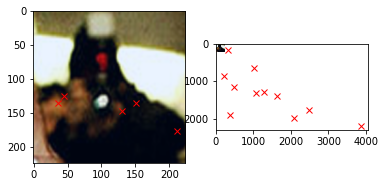

Minibatch 1/4682. Loss 0.031430695205926895
Minibatch 51/4682. Loss 0.027004852890968323
Minibatch 101/4682. Loss 0.031540706753730774
Minibatch 151/4682. Loss 0.02862710878252983
Minibatch 201/4682. Loss 0.02787894383072853
Minibatch 251/4682. Loss 0.028870414942502975
Minibatch 301/4682. Loss 0.032754939049482346
Minibatch 351/4682. Loss 0.025669170543551445
Minibatch 401/4682. Loss 0.023801619186997414
Minibatch 451/4682. Loss 0.03496577590703964
Minibatch 501/4682. Loss 0.03580925613641739
Minibatch 551/4682. Loss 0.024958044290542603
Minibatch 601/4682. Loss 0.03529656305909157
Minibatch 651/4682. Loss 0.02844366431236267
Minibatch 701/4682. Loss 0.03906484320759773
Minibatch 751/4682. Loss 0.03765998035669327
Minibatch 801/4682. Loss 0.02224225178360939
Minibatch 851/4682. Loss 0.0351632758975029
Minibatch 901/4682. Loss 0.02764841727912426
Minibatch 951/4682. Loss 0.03375284746289253
Minibatch 1001/4682. Loss 0.03248632699251175
Minibatch 1051/4682. Loss 0.030334487557411194
Min

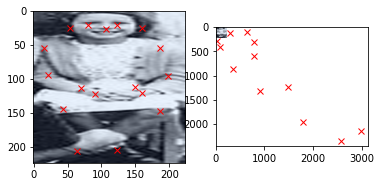

Minibatch 1/4682. Loss 0.02699393965303898
Minibatch 51/4682. Loss 0.030365804210305214
Minibatch 101/4682. Loss 0.022925497964024544
Minibatch 151/4682. Loss 0.028744187206029892
Minibatch 201/4682. Loss 0.03544730320572853
Minibatch 251/4682. Loss 0.02471938356757164
Minibatch 301/4682. Loss 0.03738081082701683
Minibatch 351/4682. Loss 0.027187960222363472
Minibatch 401/4682. Loss 0.036350760608911514
Minibatch 451/4682. Loss 0.038418784737586975
Minibatch 501/4682. Loss 0.03319433331489563
Minibatch 551/4682. Loss 0.03176253288984299
Minibatch 601/4682. Loss 0.03208648040890694
Minibatch 651/4682. Loss 0.027931861579418182
Minibatch 701/4682. Loss 0.02642078697681427
Minibatch 751/4682. Loss 0.03796958178281784
Minibatch 801/4682. Loss 0.024246422573924065
Minibatch 851/4682. Loss 0.03134094923734665
Minibatch 901/4682. Loss 0.03543345630168915
Minibatch 951/4682. Loss 0.03440133482217789
Minibatch 1001/4682. Loss 0.036473553627729416
Minibatch 1051/4682. Loss 0.036682408303022385
M

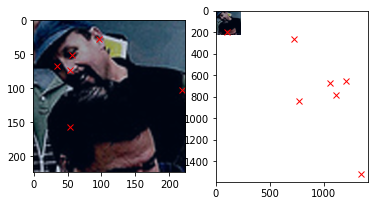

Minibatch 1/4682. Loss 0.03602050244808197
Minibatch 51/4682. Loss 0.029121335595846176
Minibatch 101/4682. Loss 0.027000809088349342
Minibatch 151/4682. Loss 0.023934949189424515
Minibatch 201/4682. Loss 0.026607351377606392
Minibatch 251/4682. Loss 0.022792205214500427
Minibatch 301/4682. Loss 0.02193428762257099
Minibatch 351/4682. Loss 0.027419982478022575
Minibatch 401/4682. Loss 0.022542603313922882
Minibatch 451/4682. Loss 0.023804321885108948
Minibatch 501/4682. Loss 0.023283975198864937
Minibatch 551/4682. Loss 0.02389584295451641
Minibatch 601/4682. Loss 0.031860142946243286
Minibatch 651/4682. Loss 0.027280982583761215
Minibatch 701/4682. Loss 0.023857517167925835
Minibatch 751/4682. Loss 0.029843645170331
Minibatch 801/4682. Loss 0.029564157128334045
Minibatch 851/4682. Loss 0.03283696994185448
Minibatch 901/4682. Loss 0.027203630656003952
Minibatch 951/4682. Loss 0.029828481376171112
Minibatch 1001/4682. Loss 0.025508664548397064
Minibatch 1051/4682. Loss 0.023338954895734

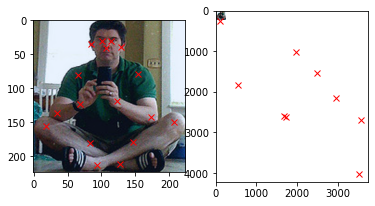

Minibatch 1/4682. Loss 0.026936586946249008
Minibatch 51/4682. Loss 0.02572977915406227
Minibatch 101/4682. Loss 0.03562942147254944
Minibatch 151/4682. Loss 0.023699939250946045
Minibatch 201/4682. Loss 0.02774907276034355
Minibatch 251/4682. Loss 0.02662869729101658
Minibatch 301/4682. Loss 0.021355384960770607
Minibatch 351/4682. Loss 0.03282343968749046
Minibatch 401/4682. Loss 0.017858775332570076
Minibatch 451/4682. Loss 0.01953657902777195
Minibatch 501/4682. Loss 0.027944739907979965
Minibatch 551/4682. Loss 0.02517545036971569
Minibatch 601/4682. Loss 0.03369796276092529
Minibatch 651/4682. Loss 0.03044361248612404
Minibatch 701/4682. Loss 0.02738150954246521
Minibatch 751/4682. Loss 0.027818551287055016
Minibatch 801/4682. Loss 0.023320423439145088
Minibatch 851/4682. Loss 0.024295605719089508
Minibatch 901/4682. Loss 0.023803625255823135
Minibatch 951/4682. Loss 0.02117406390607357
Minibatch 1001/4682. Loss 0.031516626477241516
Minibatch 1051/4682. Loss 0.027518896386027336


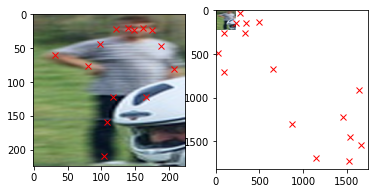

Minibatch 1/4682. Loss 0.02528185397386551
Minibatch 51/4682. Loss 0.026348408311605453
Minibatch 101/4682. Loss 0.017793532460927963
Minibatch 151/4682. Loss 0.027336305007338524
Minibatch 201/4682. Loss 0.02659604139626026
Minibatch 251/4682. Loss 0.02550670877099037
Minibatch 301/4682. Loss 0.024868501350283623
Minibatch 351/4682. Loss 0.019471485167741776
Minibatch 401/4682. Loss 0.021987609565258026
Minibatch 451/4682. Loss 0.026094352826476097
Minibatch 501/4682. Loss 0.029132600873708725
Minibatch 551/4682. Loss 0.03542914241552353
Minibatch 601/4682. Loss 0.02515527419745922
Minibatch 651/4682. Loss 0.016890333965420723
Minibatch 701/4682. Loss 0.018992319703102112
Minibatch 751/4682. Loss 0.026957588270306587
Minibatch 801/4682. Loss 0.03375046327710152
Minibatch 851/4682. Loss 0.03151026740670204
Minibatch 901/4682. Loss 0.030438974499702454
Minibatch 951/4682. Loss 0.024058829993009567
Minibatch 1001/4682. Loss 0.021272193640470505
Minibatch 1051/4682. Loss 0.024599798023700

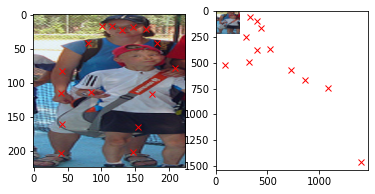

Minibatch 1/4682. Loss 0.021787747740745544
Minibatch 51/4682. Loss 0.029463283717632294
Minibatch 101/4682. Loss 0.02135971002280712
Minibatch 151/4682. Loss 0.020185427740216255
Minibatch 201/4682. Loss 0.02314334735274315
Minibatch 251/4682. Loss 0.029274875298142433
Minibatch 301/4682. Loss 0.01909426599740982
Minibatch 351/4682. Loss 0.024405810981988907
Minibatch 401/4682. Loss 0.025960681959986687
Minibatch 451/4682. Loss 0.02189573086798191
Minibatch 501/4682. Loss 0.031171798706054688
Minibatch 551/4682. Loss 0.019367750734090805
Minibatch 601/4682. Loss 0.02667980268597603
Minibatch 651/4682. Loss 0.022551782429218292
Minibatch 701/4682. Loss 0.02075759693980217
Minibatch 751/4682. Loss 0.029059773311018944
Minibatch 801/4682. Loss 0.01942792907357216
Minibatch 851/4682. Loss 0.01965036801993847
Minibatch 901/4682. Loss 0.02419614978134632
Minibatch 951/4682. Loss 0.02213076688349247
Minibatch 1001/4682. Loss 0.018635334447026253
Minibatch 1051/4682. Loss 0.02496987208724022


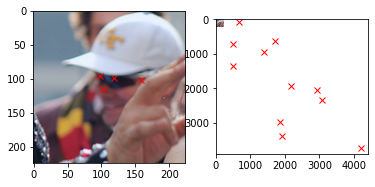

Minibatch 1/4682. Loss 0.029384082183241844
Minibatch 51/4682. Loss 0.023139940574765205
Minibatch 101/4682. Loss 0.020323053002357483
Minibatch 151/4682. Loss 0.020598700270056725
Minibatch 201/4682. Loss 0.019043561071157455
Minibatch 251/4682. Loss 0.017451634630560875
Minibatch 301/4682. Loss 0.020182430744171143
Minibatch 351/4682. Loss 0.023438239470124245
Minibatch 401/4682. Loss 0.01743452623486519
Minibatch 451/4682. Loss 0.020399706438183784
Minibatch 501/4682. Loss 0.022726789116859436
Minibatch 551/4682. Loss 0.023263948038220406
Minibatch 601/4682. Loss 0.0205252543091774
Minibatch 651/4682. Loss 0.024352824315428734
Minibatch 701/4682. Loss 0.019367828965187073
Minibatch 751/4682. Loss 0.01921137236058712
Minibatch 801/4682. Loss 0.017753029242157936
Minibatch 851/4682. Loss 0.021947959437966347
Minibatch 901/4682. Loss 0.023229574784636497
Minibatch 951/4682. Loss 0.021746328100562096
Minibatch 1001/4682. Loss 0.020077547058463097
Minibatch 1051/4682. Loss 0.023902511224

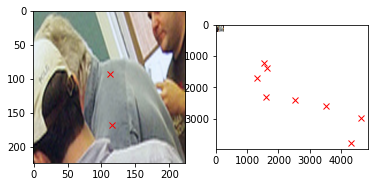

Minibatch 1/4682. Loss 0.020863549783825874
Minibatch 51/4682. Loss 0.021584855392575264
Minibatch 101/4682. Loss 0.014373713172972202
Minibatch 151/4682. Loss 0.024996351450681686
Minibatch 201/4682. Loss 0.018659047782421112
Minibatch 251/4682. Loss 0.01443110778927803
Minibatch 301/4682. Loss 0.020217282697558403
Minibatch 351/4682. Loss 0.019093461334705353
Minibatch 401/4682. Loss 0.014682120643556118
Minibatch 451/4682. Loss 0.019445938989520073
Minibatch 501/4682. Loss 0.02398252859711647
Minibatch 551/4682. Loss 0.020497487857937813
Minibatch 601/4682. Loss 0.02014990895986557
Minibatch 651/4682. Loss 0.02856614626944065
Minibatch 701/4682. Loss 0.018144385889172554
Minibatch 751/4682. Loss 0.02547444775700569
Minibatch 801/4682. Loss 0.029521998018026352
Minibatch 851/4682. Loss 0.029642784968018532
Minibatch 901/4682. Loss 0.020729437470436096
Minibatch 951/4682. Loss 0.02103956788778305
Minibatch 1001/4682. Loss 0.0194835402071476
Minibatch 1051/4682. Loss 0.0194868277758359

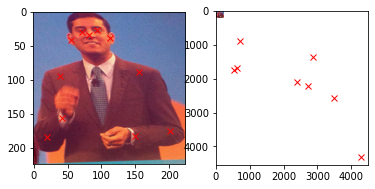

Minibatch 1/4682. Loss 0.018277667462825775
Minibatch 51/4682. Loss 0.02274206280708313
Minibatch 101/4682. Loss 0.025337940081954002
Minibatch 151/4682. Loss 0.025253063067793846
Minibatch 201/4682. Loss 0.017826227471232414
Minibatch 251/4682. Loss 0.017910325899720192
Minibatch 301/4682. Loss 0.01904498226940632
Minibatch 351/4682. Loss 0.01668725721538067
Minibatch 401/4682. Loss 0.01934664696455002
Minibatch 451/4682. Loss 0.019982023164629936
Minibatch 501/4682. Loss 0.02262822352349758
Minibatch 551/4682. Loss 0.020467951893806458
Minibatch 601/4682. Loss 0.019249310716986656
Minibatch 651/4682. Loss 0.018056808039546013
Minibatch 701/4682. Loss 0.021873971447348595
Minibatch 751/4682. Loss 0.017050473019480705
Minibatch 801/4682. Loss 0.020594509318470955
Minibatch 851/4682. Loss 0.019705533981323242
Minibatch 901/4682. Loss 0.022383110597729683
Minibatch 951/4682. Loss 0.014879356138408184
Minibatch 1001/4682. Loss 0.022237515076994896
Minibatch 1051/4682. Loss 0.0190904773771

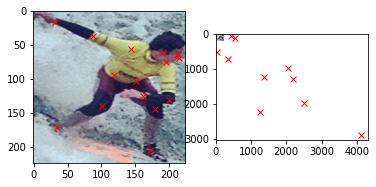

Minibatch 1/4682. Loss 0.017215872183442116
Minibatch 51/4682. Loss 0.02001233398914337
Minibatch 101/4682. Loss 0.01945708692073822
Minibatch 151/4682. Loss 0.02373715117573738
Minibatch 201/4682. Loss 0.012190262787044048
Minibatch 251/4682. Loss 0.014660815708339214
Minibatch 301/4682. Loss 0.01740085519850254
Minibatch 351/4682. Loss 0.019504105672240257
Minibatch 401/4682. Loss 0.020585063844919205
Minibatch 451/4682. Loss 0.018621958792209625
Minibatch 501/4682. Loss 0.020040595903992653
Minibatch 551/4682. Loss 0.017482813447713852
Minibatch 601/4682. Loss 0.012639225460588932
Minibatch 651/4682. Loss 0.014997893944382668
Minibatch 701/4682. Loss 0.01905171386897564
Minibatch 751/4682. Loss 0.015192365273833275
Minibatch 801/4682. Loss 0.023460717871785164
Minibatch 851/4682. Loss 0.020664488896727562
Minibatch 901/4682. Loss 0.017366226762533188
Minibatch 951/4682. Loss 0.020750856027007103
Minibatch 1001/4682. Loss 0.02007557637989521
Minibatch 1051/4682. Loss 0.01697286218404

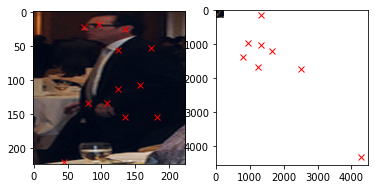

Minibatch 1/4682. Loss 0.020051924511790276
Minibatch 51/4682. Loss 0.02234361134469509
Minibatch 101/4682. Loss 0.01724531315267086
Minibatch 151/4682. Loss 0.013473780825734138
Minibatch 201/4682. Loss 0.021006746217608452
Minibatch 251/4682. Loss 0.020074203610420227
Minibatch 301/4682. Loss 0.017569076269865036
Minibatch 351/4682. Loss 0.026669293642044067
Minibatch 401/4682. Loss 0.01444956660270691
Minibatch 451/4682. Loss 0.024817436933517456
Minibatch 501/4682. Loss 0.021533893421292305
Minibatch 551/4682. Loss 0.016860798001289368
Minibatch 601/4682. Loss 0.01567477360367775
Minibatch 651/4682. Loss 0.021009907126426697
Minibatch 701/4682. Loss 0.018230227753520012
Minibatch 751/4682. Loss 0.017282983288168907
Minibatch 801/4682. Loss 0.021728144958615303
Minibatch 851/4682. Loss 0.015315077267587185
Minibatch 901/4682. Loss 0.016011996194720268
Minibatch 951/4682. Loss 0.0206128042191267
Minibatch 1001/4682. Loss 0.017186474055051804
Minibatch 1051/4682. Loss 0.01823143847286

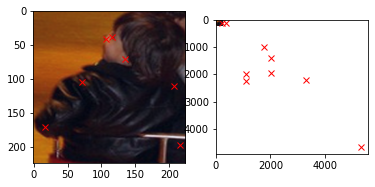

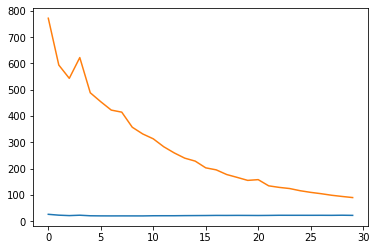

In [49]:
# TRAINING
train_dataset = Coco(train_coco_df, 'train', 224, transform=composed_transforms)
batch_size = 32
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, shuffle=True, num_workers=0
)

# Define loss and optimizer
criterion = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

epochs = 30

print(f"Training {epochs} epochs. Dataset is {len(train_dataset)} big. Using batch size {batch_size}")
print(f"{len(train_dataset)//batch_size+1} minibatches are needed per epoch")

train_loss_history = []
val_loss_history = []

# Train for 2 epochs
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 0:
            print(f"Minibatch {i+1}/{len(train_dataset)//batch_size+1}. Loss {loss.item()}")

    # print statistics
    print(f"Epoch {epoch}/2. Loss {running_loss}")
    train_loss_history.append(running_loss)
    val_loss_history.append(check_validation_accuracy(model))

# save model
plt.plot(val_loss_history)
plt.plot(train_loss_history)
torch.save(model.state_dict(), 'model.save')